In [142]:
%load_ext autoreload
%autoreload 2

import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List
from utils import *
from prune_utils import *

import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
# import matplotlib.pyplot as plt
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm
import torchvision.models as models

from torchprofile import profile_macs

assert torch.cuda.is_available(), \
"CUDA support is not available."

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [6]:
backbone = models.vgg16(pretrained=True)

/home/soheil/miniconda3/envs/hardwareAcc/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/soheil/miniconda3/envs/hardwareAcc/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
dataloader = get_dataloader()

Files already downloaded and verified
Files already downloaded and verified


In [9]:
model = nn.Sequential(OrderedDict([('backbone', backbone), ('non-linearity', nn.ReLU(inplace=True)),('classifier', nn.Linear(1000, 100))])).cuda()
base_model = copy.deepcopy(model)

In [10]:
print(model)

Sequential(
  (backbone): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [12]:
base_model.load_state_dict(torch.load('base_model.pth'))

<All keys matched successfully>

In [14]:
evaluate_model(base_model, dataloader)

model has test accuracy=65.04%
model has train accuracy=85.14%
model has size=528.17 MiB
model has macs=0.44 Gmacs
average inference time is 0.0027 seconds
model has 138.46 M parameters


In [19]:
model.backbone.classifier._modules['0'] = nn.Identity()
model.backbone.classifier._modules['1'] = nn.Identity()
model.backbone.classifier._modules['2'] = nn.Identity()
model.backbone.classifier._modules['3'] = nn.Identity()
model.backbone.classifier._modules['4'] = nn.Identity()
model.backbone.classifier._modules['5'] = nn.Identity()
model.backbone.classifier._modules['6'] = nn.Identity()
model._modules['non-linearity'] = nn.Identity()
model._modules['classifier'] = nn.Linear(25088, 100, bias=True).cuda()

In [20]:
print(model)

Sequential(
  (backbone): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [74]:
model.load_state_dict(torch.load('model.pth')) 

<All keys matched successfully>

In [75]:
evaluate_model(model, dataloader)

model has test accuracy=64.90%
model has train accuracy=88.79%
model has size=65.70 MiB
model has macs=0.32 Gmacs
average inference time is 0.0012 seconds
model has 17.22 M parameters


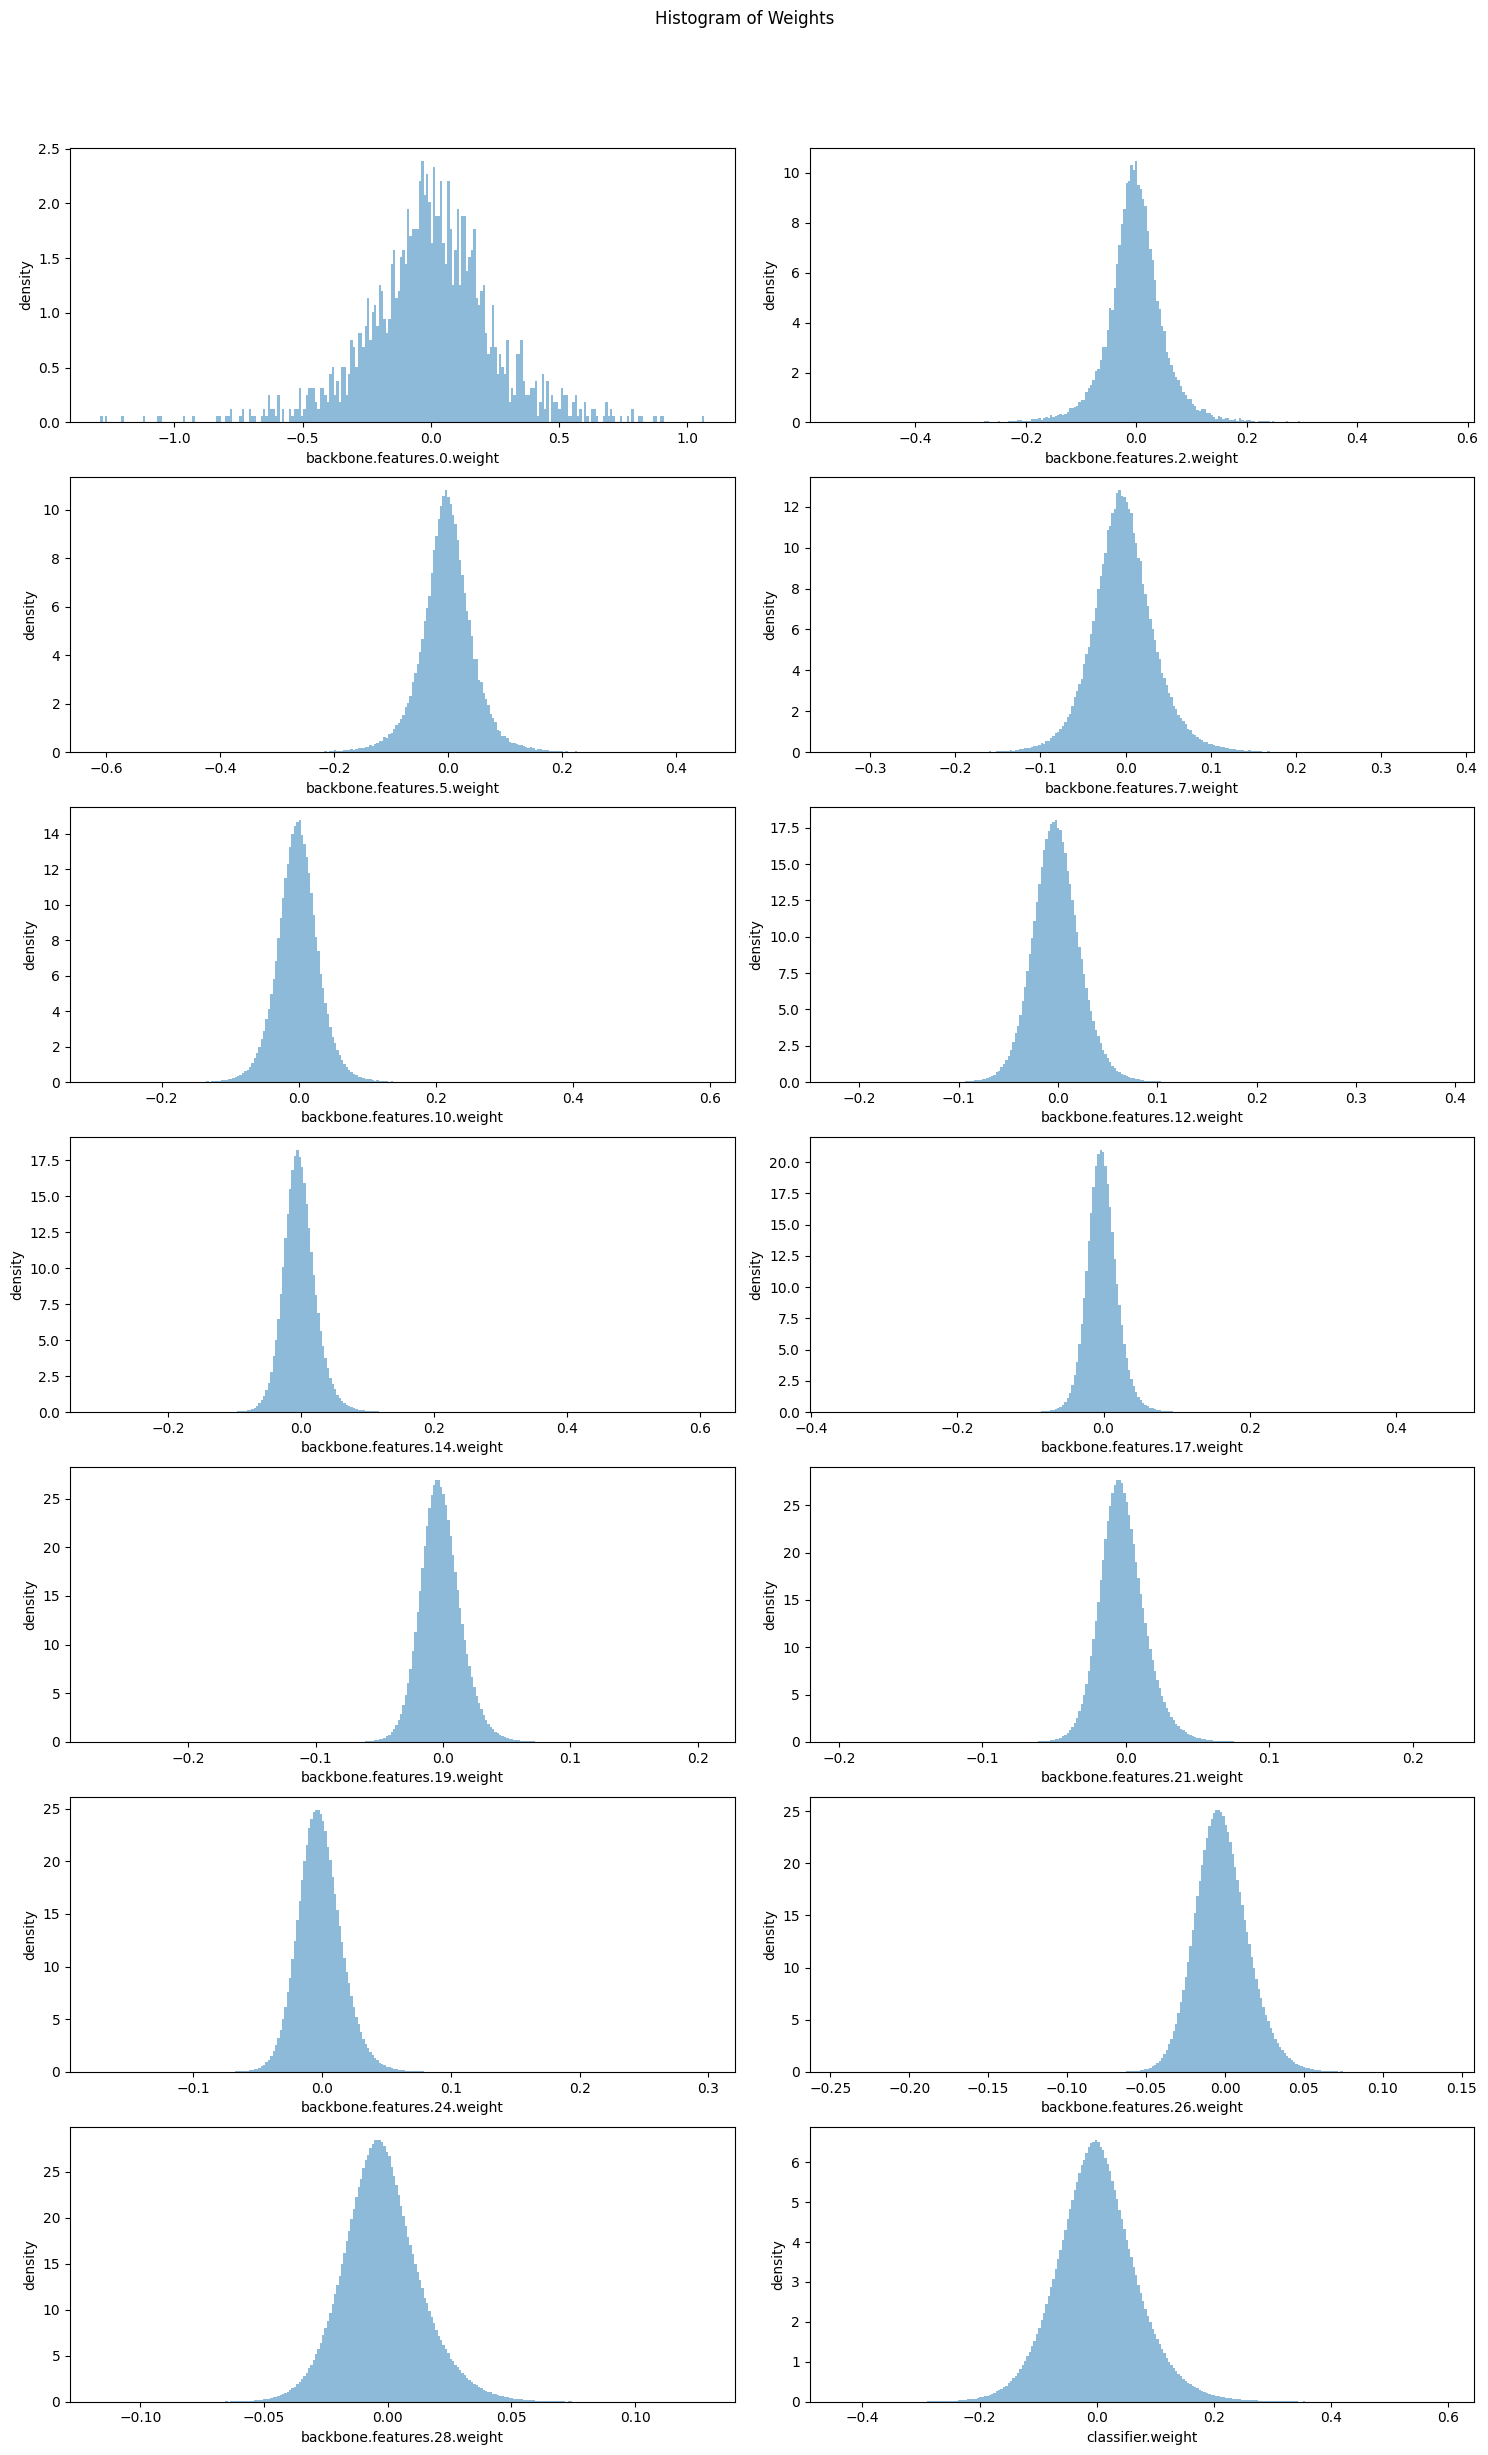

In [76]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=True):
    fig, axes = plt.subplots(7,2, figsize=(15, 25))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True, 
                        alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True, 
                        alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

In [37]:
sparsities, accuracies = sensitivity_scan(model, dataloader['test'], scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=False)

scanning 0/14 weight - backbone.features.0.weight: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]
scanning 1/14 weight - backbone.features.2.weight: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]
scanning 2/14 weight - backbone.features.5.weight: 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]
scanning 3/14 weight - backbone.features.7.weight: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]
scanning 4/14 weight - backbone.features.10.weight: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]
scanning 5/14 weight - backbone.features.12.weight: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]
scanning 6/14 weight - backbone.features.14.weight: 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]
scanning 7/14 weight - backbone.features.17.weight: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]
scanning 8/14 weight - backbone.features.19.weight: 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]
scanning 9/14 weight - backbone.features.21.weight: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]
scanning 10/14 weight - 

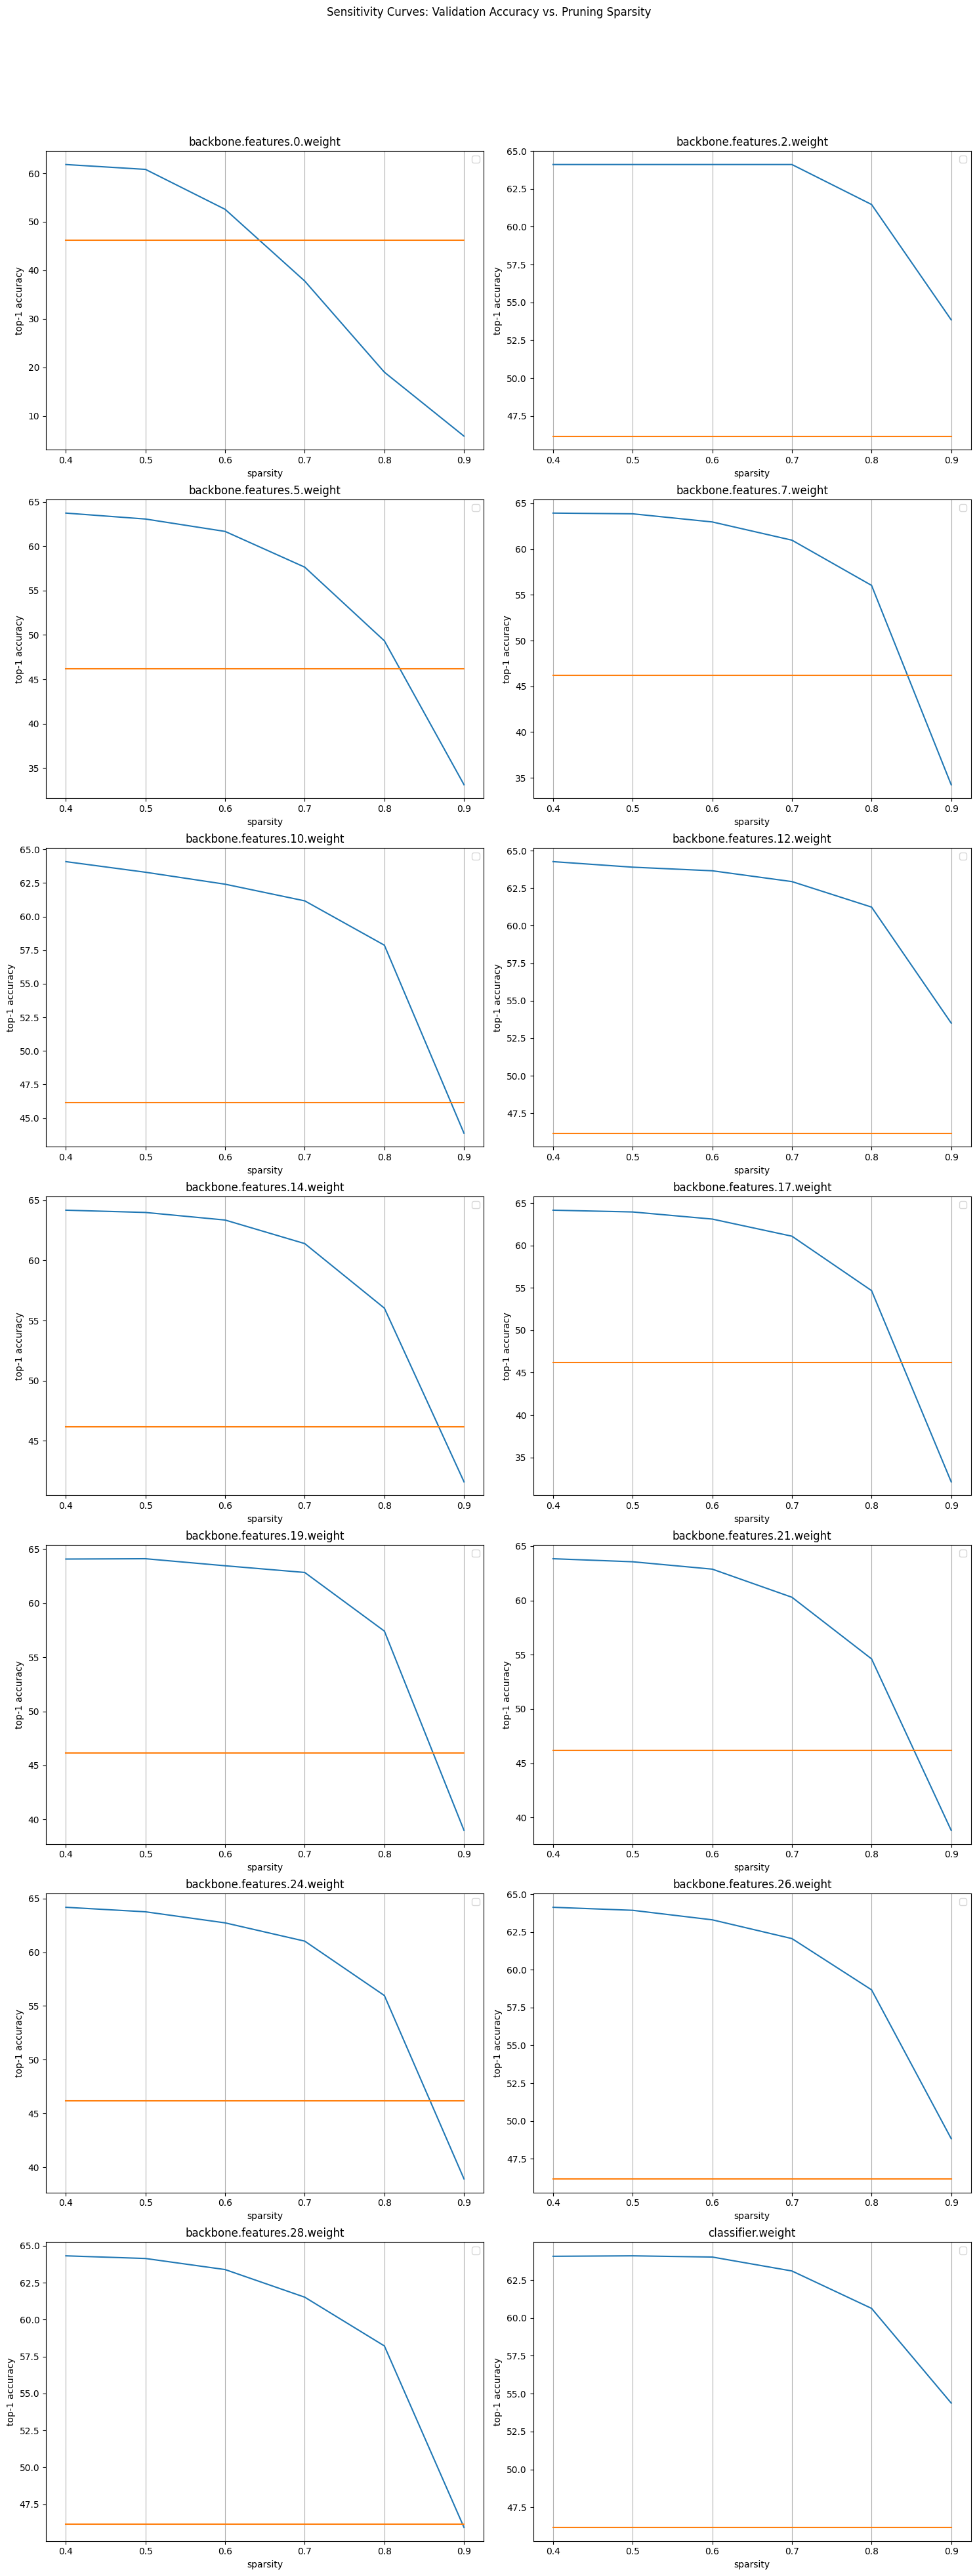

In [67]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(7, 2 ,figsize=(15, 40))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            # curve = ax.plot(sparsities, accuracies[plot_index])
            # line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            # ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            # ax.set_ylim(80, 95)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
            ])
            ax.plot(sparsities, accuracies[plot_index])
            ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

dense_model_accuracy = evaluate(model, dataloader['test'])
plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

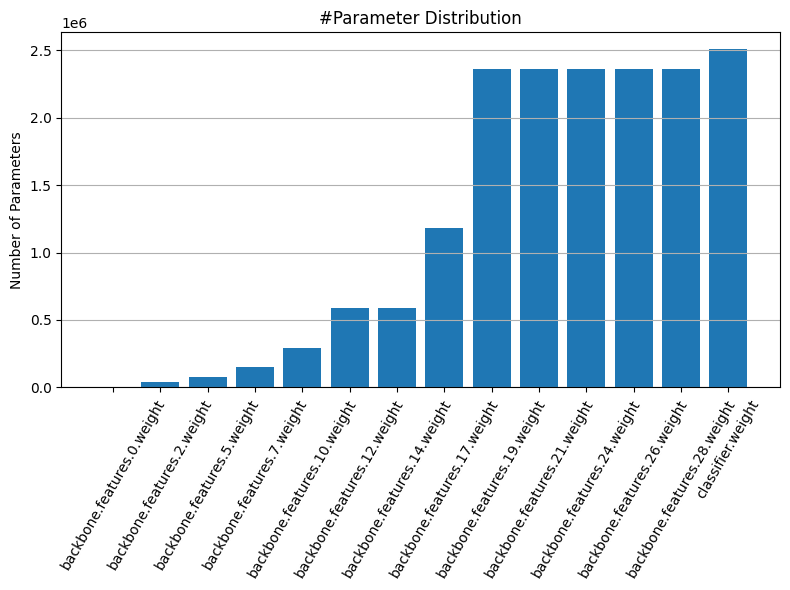

In [68]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

In [77]:
dense_model = copy.deepcopy(model)

In [95]:
model = copy.deepcopy(dense_model)

In [96]:
sparsity_dict = {

    # please modify the sparsity value of each layer
    # please DO NOT modify the key of sparsity_dict
    
    'backbone.features.0.weight': .0,
    'backbone.features.2.weight': .5,
    'backbone.features.5.weight': .5,
    'backbone.features.7.weight': .5,
    'backbone.features.10.weight': .5,
    'backbone.features.12.weight': .5,
    'backbone.features.14.weight': .5,
    'backbone.features.17.weight': .5,
    'backbone.features.19.weight': .5,
    'backbone.features.21.weight': .5,
    'backbone.features.24.weight': .5,
    'backbone.features.26.weight': .5,
    'backbone.features.28.weight': .5,
    'classifier.weight': .5

}

After pruning with sparsity dictionary
  backbone.features.0.weight: 0.00
  backbone.features.2.weight: 0.50
  backbone.features.5.weight: 0.50
  backbone.features.7.weight: 0.50
  backbone.features.10.weight: 0.50
  backbone.features.12.weight: 0.50
  backbone.features.14.weight: 0.50
  backbone.features.17.weight: 0.50
  backbone.features.19.weight: 0.50
  backbone.features.21.weight: 0.50
  backbone.features.24.weight: 0.50
  backbone.features.26.weight: 0.50
  backbone.features.28.weight: 0.50
  classifier.weight: 0.50
The sparsity of each layer becomes
  backbone.features.0.weight: 0.00
  backbone.features.2.weight: 0.50
  backbone.features.5.weight: 0.50
  backbone.features.7.weight: 0.50
  backbone.features.10.weight: 0.50
  backbone.features.12.weight: 0.50
  backbone.features.14.weight: 0.50
  backbone.features.17.weight: 0.50
  backbone.features.19.weight: 0.50
  backbone.features.21.weight: 0.50
  backbone.features.24.weight: 0.50
  backbone.features.26.weight: 0.50
  backbo

Sparse model has accuracy=60.87% before fintuning


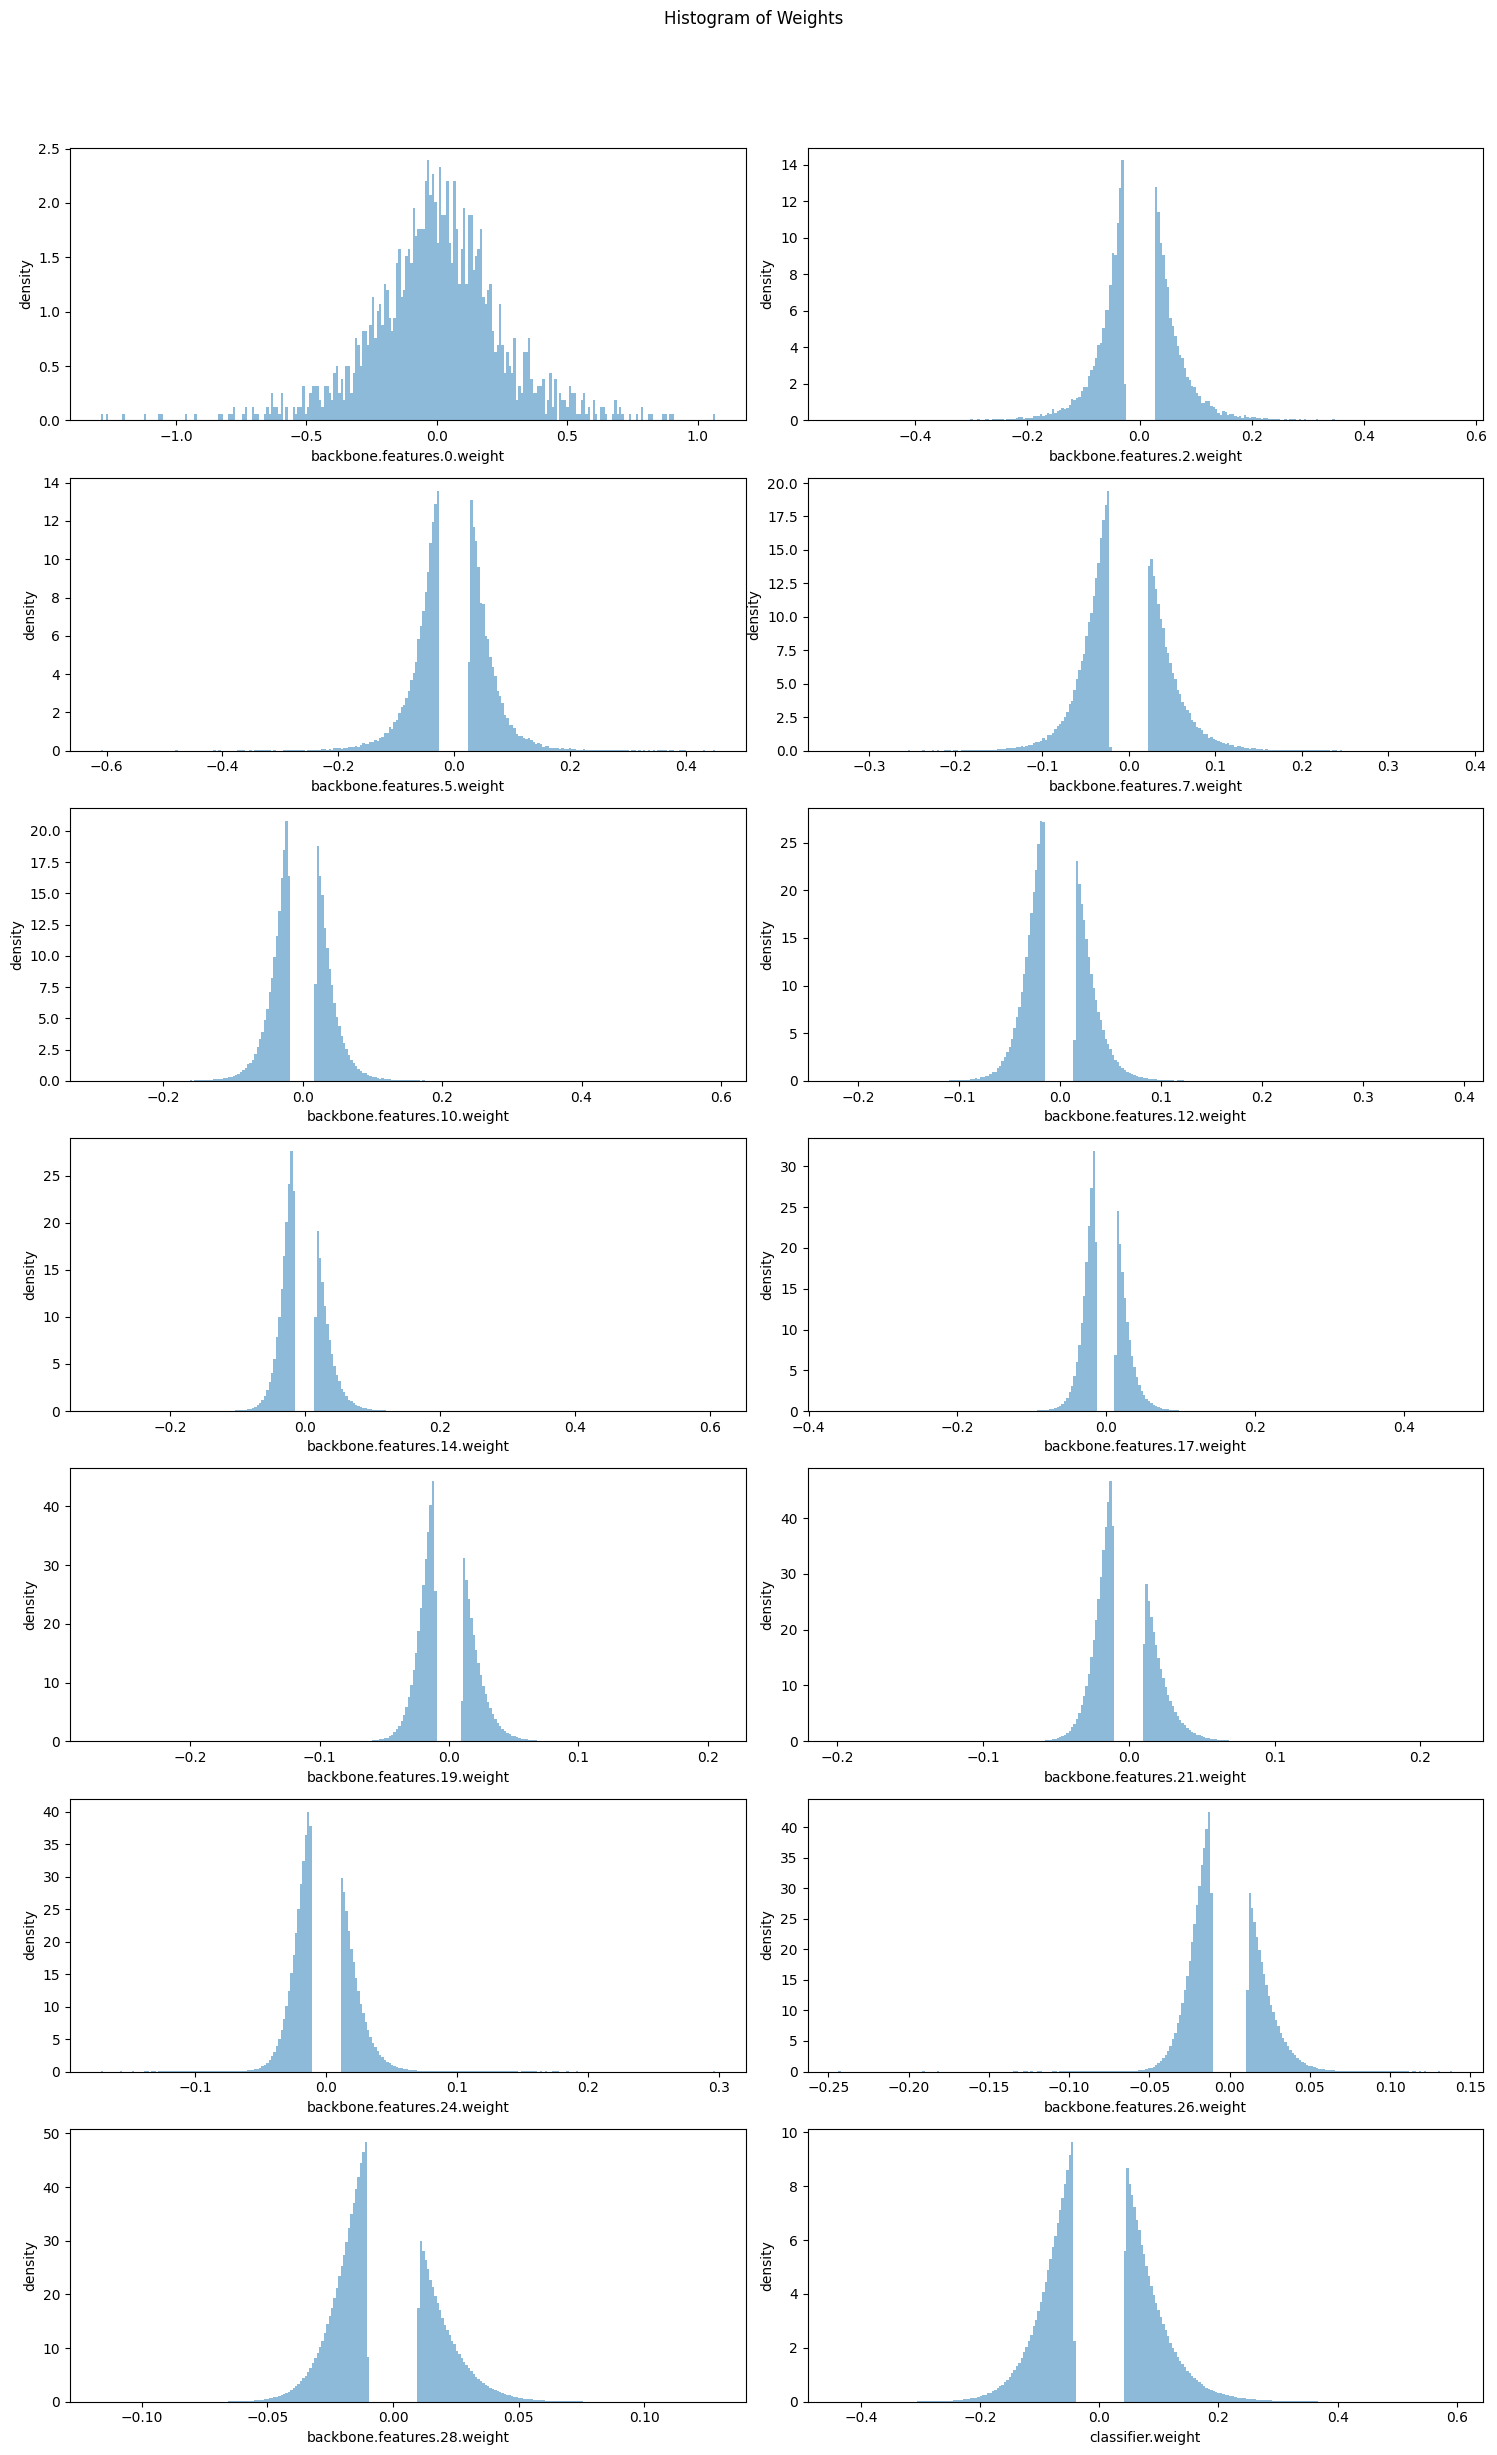

In [97]:
pruner = FineGrainedPruner(model, sparsity_dict)
dense_model_size = get_model_size(dense_model)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

plot_weight_distribution(model, count_nonzero_only=True)

In [98]:
finetune(model, dataloader, num_finetune_epochs=5, lr=1e-4)

Finetuning Fine-grained Pruned Sparse Model


    Epoch 1 Accuracy 63.35% / Best Accuracy: 63.35%


    Epoch 2 Accuracy 63.85% / Best Accuracy: 63.85%


    Epoch 3 Accuracy 64.18% / Best Accuracy: 64.18%


    Epoch 4 Accuracy 64.39% / Best Accuracy: 64.39%


    Epoch 5 Accuracy 64.46% / Best Accuracy: 64.46%


([84.03799438476562,
  84.69000244140625,
  85.49999237060547,
  85.82999420166016,
  86.19200134277344],
 [63.349998474121094,
  63.849998474121094,
  64.18000030517578,
  64.38999938964844,
  64.45999908447266])

In [99]:
evaluate_model(model, dataloader)

model has test accuracy=64.46%
model has train accuracy=85.95%
model has size=65.70 MiB
model has macs=0.32 Gmacs
average inference time is 0.0008 seconds
model has 17.22 M parameters


In [103]:
pruner = FineGrainedPruner(model, sparsity_dict)
evaluate_model(model, dataloader, count_nonzero_only=True)

model has test accuracy=63.36%
model has train accuracy=84.04%
model has size=32.86 MiB
model has macs=0.32 Gmacs
average inference time is 0.0008 seconds
model has 8.61 M parameters


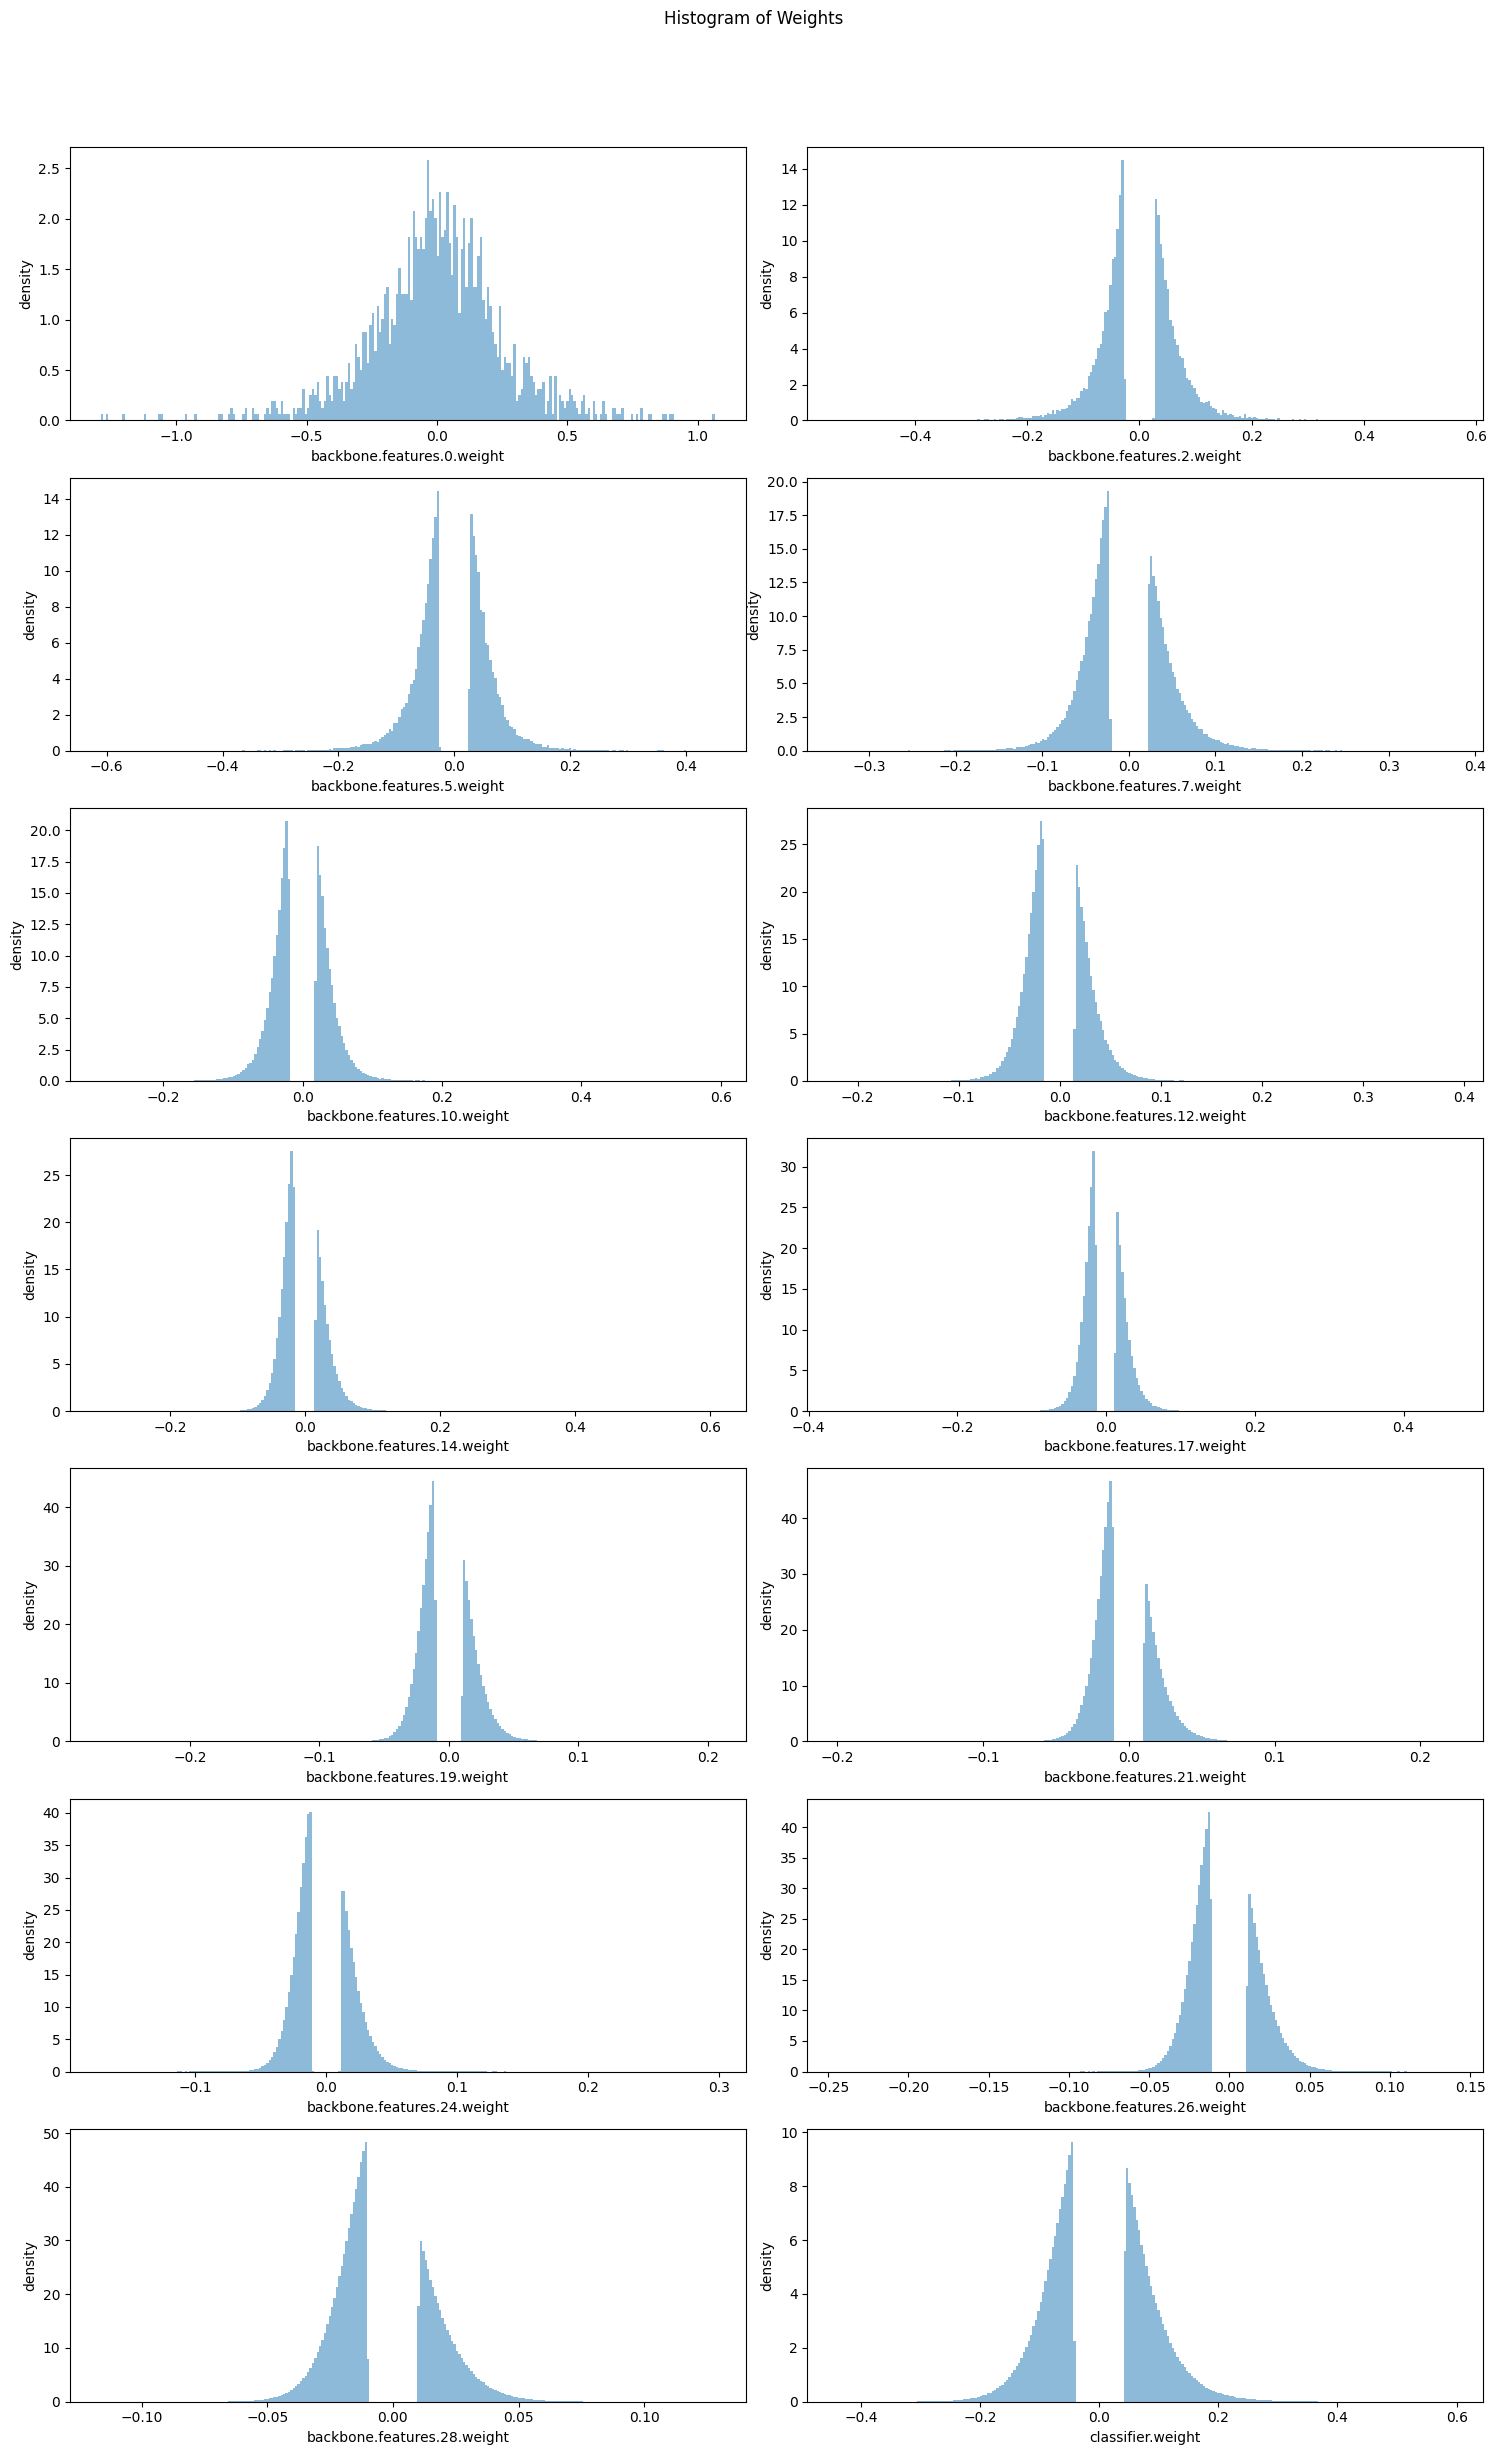

In [104]:
plot_weight_distribution(model, count_nonzero_only=True)

In [91]:
pruner = FineGrainedPruner(model, sparsity_dict)
finetune(model, dataloader, num_finetune_epochs=10, lr=1e-4)

Finetuning Fine-grained Pruned Sparse Model


    Epoch 1 Accuracy 45.42% / Best Accuracy: 45.42%


    Epoch 2 Accuracy 50.11% / Best Accuracy: 50.11%


    Epoch 3 Accuracy 52.11% / Best Accuracy: 52.11%


    Epoch 4 Accuracy 53.69% / Best Accuracy: 53.69%


    Epoch 5 Accuracy 54.83% / Best Accuracy: 54.83%


    Epoch 6 Accuracy 55.48% / Best Accuracy: 55.48%


    Epoch 7 Accuracy 55.90% / Best Accuracy: 55.90%


    Epoch 8 Accuracy 56.97% / Best Accuracy: 56.97%


    Epoch 9 Accuracy 57.30% / Best Accuracy: 57.30%


    Epoch 10 Accuracy 57.92% / Best Accuracy: 57.92%


([48.65999984741211,
  53.641998291015625,
  56.375999450683594,
  58.38800048828125,
  59.92599868774414,
  61.236000061035156,
  62.09600067138672,
  62.7760009765625,
  63.9119987487793,
  64.7959976196289],
 [45.41999816894531,
  50.11000061035156,
  52.1099967956543,
  53.689998626708984,
  54.82999801635742,
  55.47999572753906,
  55.900001525878906,
  56.970001220703125,
  57.30000305175781,
  57.91999816894531])

In [93]:
evaluate_model(dense_model, dataloader, count_nonzero_only=True)

model has test accuracy=64.90%
model has train accuracy=88.72%
model has size=65.70 MiB
model has macs=0.32 Gmacs
average inference time is 0.0008 seconds
model has 17.22 M parameters


In [105]:
# pruner = FineGrainedPruner(model, sparsity_dict)
evaluate_model(model, dataloader, count_nonzero_only=True)

model has test accuracy=63.36%
model has train accuracy=84.03%
model has size=32.86 MiB
model has macs=0.32 Gmacs
average inference time is 0.0008 seconds
model has 8.61 M parameters


# Channel pruning

In [155]:
from prune_utils import channel_prune
channel_pruned_model = channel_prune(dense_model, prune_ratio=0.1)

In [147]:
evaluate_model(dense_model, dataloader, count_nonzero_only=True)

model has test accuracy=64.90%
model has train accuracy=88.82%
model has size=65.70 MiB
model has macs=0.32 Gmacs
average inference time is 0.0008 seconds
model has 17.22 M parameters


In [156]:
evaluate_model(channel_pruned_model, dataloader, count_nonzero_only=True)

model has test accuracy=24.73%
model has train accuracy=23.21%
model has size=55.86 MiB
model has macs=0.26 Gmacs
average inference time is 0.0011 seconds
model has 14.64 M parameters


In [157]:
finetune(channel_pruned_model, dataloader, num_finetune_epochs=10, lr=1e-4)

Finetuning Fine-grained Pruned Sparse Model


    Epoch 1 Accuracy 50.84% / Best Accuracy: 50.84%


    Epoch 2 Accuracy 53.99% / Best Accuracy: 53.99%


    Epoch 3 Accuracy 55.29% / Best Accuracy: 55.29%


    Epoch 4 Accuracy 56.41% / Best Accuracy: 56.41%


    Epoch 5 Accuracy 57.23% / Best Accuracy: 57.23%


    Epoch 6 Accuracy 57.95% / Best Accuracy: 57.95%


    Epoch 7 Accuracy 58.35% / Best Accuracy: 58.35%


    Epoch 8 Accuracy 58.72% / Best Accuracy: 58.72%


    Epoch 9 Accuracy 59.22% / Best Accuracy: 59.22%


    Epoch 10 Accuracy 59.50% / Best Accuracy: 59.50%


([58.64799499511719,
  63.236000061035156,
  65.61599731445312,
  67.44400024414062,
  68.92399597167969,
  69.76399993896484,
  70.88800048828125,
  71.20999908447266,
  72.42400360107422,
  72.89999389648438],
 [50.839996337890625,
  53.9900016784668,
  55.28999710083008,
  56.409996032714844,
  57.22999572753906,
  57.94999694824219,
  58.349998474121094,
  58.71999740600586,
  59.21999740600586,
  59.499996185302734])

In [158]:
evaluate_model(channel_pruned_model, dataloader, count_nonzero_only=True)

model has test accuracy=59.50%
model has train accuracy=72.99%
model has size=55.86 MiB
model has macs=0.26 Gmacs
average inference time is 0.0012 seconds
model has 14.64 M parameters
